In [1]:
import brightway2 as bw
import pandas as pd
import numpy as np
import bw2analyzer as bw2analyzer
import bw2data as bd
import bw2calc as bc
import bw2io as bi
import plotly.express as px
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.figure_factory as ff
from scipy import stats
from matplotlib import colors as mcolors

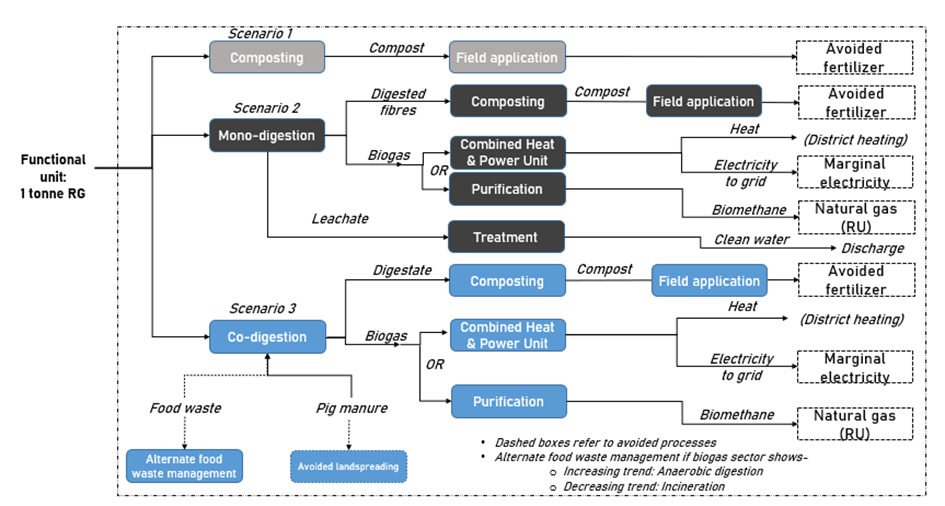

In [ ]:
#Check projects
bw.projects

In [ ]:
#Set current project
bw.projects.set_current('Manuscript_grassification')

In [ ]:
#LCIA method in a list

mymethod = [('EF v3.0', 'acidification', 'accumulated exceedance (ae)'),
            ('EF v3.0', 'human toxicity: carcinogenic', 'comparative toxic unit for human (CTUh) '),
            ('EF v3.0', 'climate change', 'global warming potential (GWP100)'),
            ('EF v3.0', 'ecotoxicity: freshwater', 'comparative toxic unit for ecosystems (CTUe) '),
            ('EF v3.0', 'eutrophication: freshwater', 'fraction of nutrients reaching freshwater end compartment (P)'),
            ('EF v3.0', 'eutrophication: marine', 'fraction of nutrients reaching marine end compartment (N)'),
            ('EF v3.0', 'eutrophication: terrestrial', 'accumulated exceedance (AE) '),
            ('EF v3.0', 'ionising radiation: human health', 'human exposure efficiency relative to u235'),
            ('EF v3.0', 'land use', 'soil quality index'),
            ('EF v3.0', 'human toxicity: non-carcinogenic', 'comparative toxic unit for human (CTUh) '),
            ('EF v3.0', 'ozone depletion', 'ozone depletion potential (ODP) '),
            ('EF v3.0', 'photochemical ozone formation: human health', 'tropospheric ozone concentration increase'),
            ('EF v3.0', 'energy resources: non-renewable', 'abiotic depletion potential (ADP): fossil fuels'),
            ('EF v3.0', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)'),
            ('EF v3.0', 'particulate matter formation', 'impact on human health'),
            ('EF v3.0', 'water use', 'user deprivation potential (deprivation-weighted water consumption)')]

In [ ]:
#Importing unit processes from the database

baseline = bw.Database("Baseline").get('53582fdda3d648838b92813a7bbad480_copy1') #Scenario1
Vanheede = bw.Database("Vanheede_NG").get('53582fdda3d648838b92813a7bbad480_copy1') #Scenario 2a, i.e. mono-digestion with CHP
Vanheede_biomethane = bw.Database("Vanheede_NG").get('53582fdda3d648838b92813a7bbad480_copy2') #Scenario 2b, i.e. mono-digestion with biogas upgrading
Inagro = bw.Database("Inagro_NG").get('f0c038860ab147e2933ca4965e963e11_copy4') #Scenario 3a, i.e. co-digestion with CHP
Inagro_biomethane = bw.Database("Inagro").get('f0c038860ab147e2933ca4965e963e11_copy6') #Scenario 3b, i.e. co-digestion with biogas upgrading

In [ ]:
#For contribution analysis using supply chain traversal
#ca = bw2analyzer.print_recursive_calculation(Scenario_1, mymethod[2], cutoff=0.01)

#A simpler method

from brightway2 import *


func_unit = baseline

lca = LCA({func_unit: 1}, mymethod[12])
lca.lci()
lca.lcia()

print(func_unit)

for exc in func_unit.technosphere():
    lca.redo_lcia({exc.input: exc['amount']})
    print(exc.input, exc['amount'], lca.score)

In [ ]:
#To check list of exchanges

#for exc in Inagro.technosphere():
    #lca.redo_lcia({exc.input: exc['amount']})
    #print(exc.input, exc['amount'], lca.score)

In [ ]:
#Placing unit processes to be compared in a list

from bw2calc.multi_lca import *

list_functional_units = [{baseline:1}, {Vanheede:1}, {Vanheede_biomethane:1}, {Inagro:1}, {Inagro_biomethane:1}]
list_methods = mymethod

In [ ]:
bw.calculation_setups['grassification'] = {'inv':list_functional_units, 'ia':list_methods}

In [ ]:
bw.calculation_setups['grassification']
myMultiLCA = bw.MultiLCA('grassification')

In [ ]:
#Creating a dataframe with results for different impact categories

overall_impacts= pd.DataFrame(index=mymethod, columns=[baseline['name'], Vanheede['name'], Vanheede_biomethane['name'], Inagro['name'], Inagro_biomethane['name']], data=myMultiLCA.results.T)
overall_impacts.to_excel(r'C:\Users\rravi\OneDrive - ugentbe\Grassification\Results\Grassification\results.xlsx')
overall_impacts

In [ ]:
OI = overall_impacts.reset_index()
OI
OI.columns = ['Impact category', 'Scenario 1', 'Scenario 2a', 'Scenario 2b', 'Scenario 3a', 'Scenario 3b']
OI.to_excel(r'C:\Users\rravi\OneDrive - ugentbe\Grassification\Results\Grassification\OI.xlsx')

In [ ]:
OI.dtypes

In [ ]:
#Upload Normalisation and weighting factors from PEF

xls = pd.ExcelFile('NF_WF.xlsx')
nf = pd.read_excel(xls,0)
nf

xls1 = pd.ExcelFile('OI.xlsx')
overall_impacts = pd.read_excel(xls1,0)
OI = overall_impacts.drop(['Unnamed: 0'], axis=1)

In [ ]:
OI

In [ ]:
#Merge existing dataframe with the normalisation and weighting dataframe

df3 = OI.merge(nf, on="Impact category", how='outer')
df3

In [ ]:
#Create dataframes for normalised and weighted results

normalised_results = df3[['Scenario 1', 'Scenario 2a', 'Scenario 2b', 'Scenario 3a', 'Scenario 3b']].divide(nf["NF"], axis="index")
weighted_results = normalised_results[['Scenario 1', 'Scenario 2a', 'Scenario 2b', 'Scenario 3a', 'Scenario 3b']].multiply(nf["WF"], axis="index")


extracted_col = OI["Impact category"]
 
weighted_results = weighted_results.join(extracted_col)
cols = weighted_results.columns.tolist()
cols = cols[-1:] + cols[:-1]

weighted_results = weighted_results[cols]
weighted_results

list=['Acidification', 'Human toxicity, cancer', 'Climate change', 'Ecotoxicity, freshwater', 'Eutrophication, freshwater',
     'Eutrophication, marine', 'Eutrophication, terrestrial', 'Ionising radiation', 'Land use', 'Human toxicity, non-cancer',
     'Ozone depletion', 'Photochemical ozone formation', 'Resource use, fossils', 'Resource use, minerals and metals', 'Particulate matter',
     'Water use']

weighted_results['IC'] = list

In [ ]:
#Export weighted results to .csv

df_final= weighted_results.drop(['Impact category'], axis=1)
df_final.to_csv('final_results.csv', sep=',')

In [ ]:
df_final.sum()

In [ ]:
#Melting dataframe of weighted results to prepare a stacked bar chart using plotly

df_melted = df_final.reset_index().melt(id_vars='IC')
df_melted_final = df_melted.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14, 15])

In [ ]:
#Setting customised template using plotly

import plotly.io as pio
import plotly.graph_objects as go
pio.templates["myname"] = go.layout.Template(
    layout=go.Layout(
        colorway=['#003366', '#E31B23', '#D81A7E', '#2790CC', '#252829', '#CC6B31', '#9AC587', 
                  '#0F62EC', '#D227F5', '#4DFF97', '#419fde', '#5C3963', '#92B7F5', '#9BBBA8', '#E9EADF', '#1D8C26']
    )
)
pio.templates.default = 'myname'

In [ ]:
#Creating stacked bar chart

fig = px.bar(df_melted_final, x="variable", y="value", color="IC", barmode = 'relative', template="myname")

fig.update_layout(
    title={'text':"Weighted impact results"},
    xaxis_title="",
    yaxis_title="points",
    legend_title="Legend Title",
    font=dict(
        family="Calibri",
        size=15,
        color="Black"
    )
)

fig.add_trace(
    go.Scatter(
        x=['Scenario 1', 'Scenario 2a', 'Scenario 2b', 'Scenario 3a', 'Scenario 3b'],
        y=[-0.0032, -0.0113, -0.0102, -0.0413, -0.0383], name='Net impact'
    ))

fig.update_layout(
    autosize=False,
    width=800,
    height=900,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    
)

fig.update_yaxes(automargin=True)

fig.show()
fig.write_image("fig1.png")

In [2]:
#Read excel file_Monte carlo results for most impacting categories
xls = pd.ExcelFile('Copy_MC.xlsx')
df1= pd.read_excel(xls, 0) #CC
df2 = pd.read_excel(xls,1) #FE
df3 = pd.read_excel(xls,2) #FDP
df4 = pd.read_excel(xls,3) #Freshwater Eutrophication
df5 = pd.read_excel(xls,4) #Terrestrial Eutrophication
df6 = pd.read_excel(xls,5) #Resource use minerals

df_CC = pd.melt(df1, id_vars =[], value_vars=['Scenario 1', 'Scenario 2a', 'Scenario 2b', 'Scenario 3a', 'Scenario 3b'])
df_FE = pd.melt(df2, id_vars=[], value_vars=['Scenario 1', 'Scenario 2a', 'Scenario 2b', 'Scenario 3a', 'Scenario 3b'])
df_FDP = pd.melt(df3, id_vars=[], value_vars=['Scenario 1', 'Scenario 2a', 'Scenario 2b', 'Scenario 3a', 'Scenario 3b']) 
df_FEutro = pd.melt(df4, id_vars=[], value_vars=['Scenario 1', 'Scenario 2a', 'Scenario 2b', 'Scenario 3a', 'Scenario 3b']) 
df_TE = pd.melt(df5, id_vars=[], value_vars=['Scenario 1', 'Scenario 2a', 'Scenario 2b', 'Scenario 3a', 'Scenario 3b']) 
df_RUM = pd.melt(df6, id_vars=[], value_vars=['Scenario 1', 'Scenario 2a', 'Scenario 2b', 'Scenario 3a', 'Scenario 3b']) 

In [3]:
df6.mean()

Scenario 1     0.000055
Scenario 2a   -0.000118
Scenario 2b    0.001039
Scenario 3a   -0.004204
Scenario 3b   -0.002027
dtype: float64

In [ ]:
#For histograms

#fig1 = px.histogram(df_CC, x="value", color="variable", nbins=800)
#fig2 = px.histogram(df_FE, x="value", color="variable")
#fig3 = px.histogram(df_FDP, x="value", color="variable")
#fig4 = px.histogram(df_FEutro, x="value", color="variable")
#fig5 = px.histogram(df_TE, x="value", color="variable")
#fig6 = px.histogram(df_RUM, x="value", color="variable", nbins=100)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize= (20,20))


ax= sns.barplot(ax=axes[0,0], x="variable", y="value", data=df_CC, color="#40B0A6")
ax.set_ylabel('kg CO2-eq', size=20)
ax.set_xlabel('')
ax.set_title('Climate change \n potential', size=18)
ax.tick_params(axis='y', labelsize=14, color='b')
ax.tick_params(axis='x', labelsize=14, color='b')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

ax1= sns.barplot(ax=axes[0,1], x="variable", y="value", data=df_FE, color="#40B0A6")
ax1.set_ylabel('CTU-eq', size=20)
ax1.set_xlabel('')
ax1.set_title('Freshwater ecotoxicity \n potential', size=18)
ax1.tick_params(axis='y', labelsize=14, color='b')
ax1.tick_params(axis='x', labelsize=14, color='b')
ax1.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

ax2= sns.barplot(ax=axes[0,2], x="variable", y="value", data=df_FDP, color="#40B0A6")
ax2.set_ylabel('MJ, net calorific value', size=20)
ax2.set_xlabel('')
ax2.set_title('Resource use, \n fossils', size=18)
ax2.tick_params(axis='y', labelsize=14, color='b')
ax2.tick_params(axis='x', labelsize=14, color='b')
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

ax3= sns.barplot(ax=axes[1,0], x="variable", y="value", data=df_FEutro, color="#40B0A6")
ax3.set_ylabel('kg PO4-eq', size=20)
ax3.set_xlabel('')
ax3.set_title('Freshwater eutrophication \n potential', size=18)
ax3.tick_params(axis='y', labelsize=14, color='b')
ax3.tick_params(axis='x', labelsize=14, color='b')
ax3.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

ax4= sns.barplot(ax=axes[1,1], x="variable", y="value", data=df_TE, color="#40B0A6")
ax4.set_ylabel('mol N-eq', size=20)
ax4.set_xlabel('')
ax4.set_title('Terrestrial eutrophication \n potential', size=18)
ax4.tick_params(axis='y', labelsize=14, color='b')
ax4.tick_params(axis='x', labelsize=14, color='b')
ax4.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

ax5= sns.barplot(ax=axes[1,2], x="variable", y="value", data=df_RUM, color="#40B0A6")
ax5.set_ylabel('kg Sb-Eq', size=20)
ax5.set_xlabel('')
ax5.set_title('Resource use, \n minerals and metals', size=18)
ax5.tick_params(axis='y', labelsize=14, color='b')
ax5.tick_params(axis='x', labelsize=14, color='b')
ax5.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6, hspace=0.4)

plt.savefig('ime.pdf', bbox_inches='tight')